# Global Diferential Privacy Assessement: Univariate case

In this notebook, we will explore the univariate case of the Global Differential Privacy using a dataset from use case 2.1. After running this notebook, you will be able to:
- Understand the concept of Global Differential Privacy.
- Apply Global Differential Privacy to a univariate dataset.

We also run a monte carl simulation to validate the GDP implementation.

## Import data and visualise

The data are imported and only available via 'pipelines' i.e. automations made by a user. As such GDP operates on the user pipeline and not directly on the data.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
!pip install wget
import wget, matplotlib
import seaborn as sns
from math import isclose
from rich import print

from src.DP import dp, user_output

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [6]:
os.makedirs("data", exist_ok=True)
link_original = "https://s3.amazonaws.com/openneuro.org/ds004148/participants.tsv?versionId=wt81Mu2B3fdeiXSis5ym288A64lXRXkR"
wget.download(link_original)
filename = "participants.tsv"
file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file == filename]
shutil.copy2(file_[0], "data")
os.remove(file_[0])
print(f"\nOriginal file downloaded.")

data = np.array(pd.read_csv("data/"+filename,sep='\s+')["Height"]).reshape(-1,1)
clean_data = data[~np.isnan(data)]
print(f"\n\tClean data: {clean_data}")

100% [..........................................................] 39886 / 39886

Original file downloaded.

Clean data: [178.   155.   169.   157.   171.   166.   167.   175.   165.   160.
 160.   156.   155.   162.   168.   165.   163.   164.   172.   180.
 160.   160.   160.   174.   162.   164.   173.   168.   160.   160.
 170.   185.   177.   177.   182.   175.   165.   175.   180.   165.
  58.   185.     1.65 167.   153.   174.   173.   175.   167.   170.
 178.   185.   172.   157.   172.   157.   171.   163.  ]

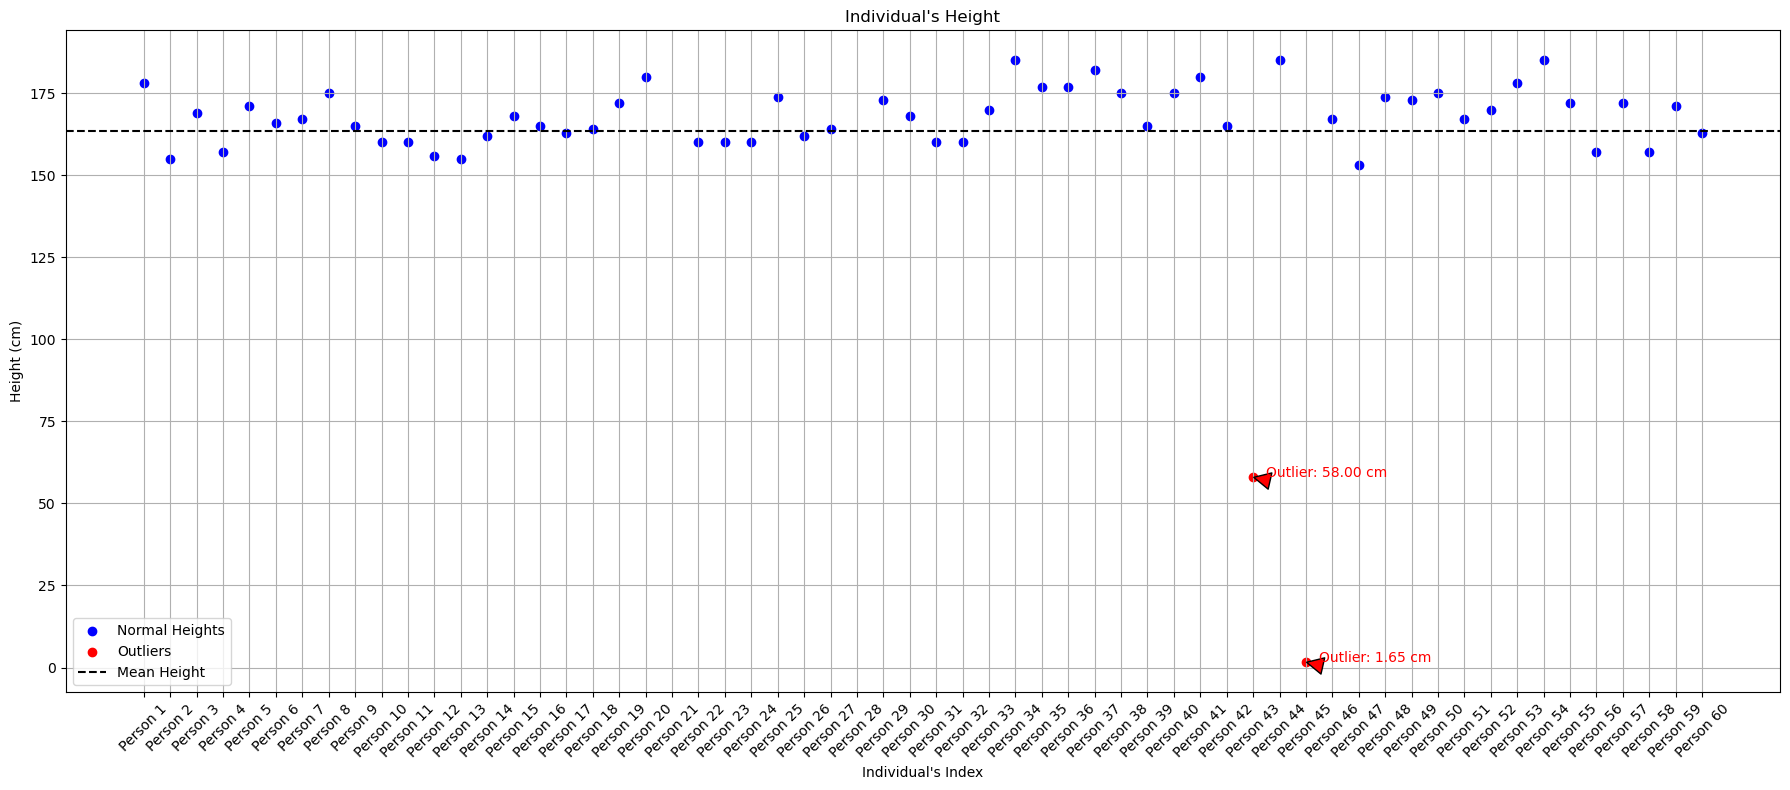

In [7]:
data = np.array(pd.read_csv("data/"+filename,sep='\s+')["Height"]).reshape(-1,1)

clean_data = data[~np.isnan(data)]
q1 = np.percentile(clean_data, 25)
q3 = np.percentile(clean_data, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

outlier_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
plt.figure(figsize=(18, 8))
normal_indices = [i for i in range(len(data)) if i not in outlier_indices]
plt.scatter(normal_indices, data[normal_indices], color='blue', label='Normal Heights')
plt.scatter(outlier_indices, data[outlier_indices], color='red', label='Outliers')

for outlier_idx in outlier_indices:
    plt.annotate(f'Outlier: {data[outlier_idx][0]:.2f} cm',
                xy=(outlier_idx, data[outlier_idx]),
                xytext=(outlier_idx+0.5, data[outlier_idx]),
                arrowprops=dict(facecolor='red', shrink=0.05),
                color='red')
plt.axhline(np.nanmean(data), color='black', linestyle='--', label='Mean Height')
plt.title("Individual's Height")
plt.xlabel("Individual's Index")
plt.xticks(range(len(data)), [f"Person {i + 1}" for i in range(len(data))], rotation=45)
plt.ylabel("Height (cm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Global Differential Privacy

Global Differential Privacy (DP) is a mathematical framework that provides strong, quantifiable privacy guarantees when analyzing and sharing data. Its core idea is to ensure that the inclusion or exclusion of a single individual’s data does not significantly affect the output of an analysis, thereby limiting what can be inferred about any one person. This limits the ability of an attacker to infer whether someone participated in the dataset, even if they possess additional background information. To achieve this, DP algorithms inject calibrated random noise into outputs.

## User Output

A data user has an analysis pipeline that s run on the data. The output of such pipeline is then made differentially private.

Here, the pipeline simply consists in computing the mean.


In [175]:
pipeline_output = user_output(clean_data)
print("the true mean is: ", user_output(clean_data))

the true mean is:  163.42499999999998

## GDP algorithm

The procedure take the user pipeline and data and applies a leave one out (loo) resampling to the data to obtain the influence function, i.e. the output of the user pipeline for each loo resample are compared to the user output. The maximum of that gives the lower bound of the noise to be applied (i.e. it provides the information on the observation which has the largest influence).  



In [176]:
loo_data = np.array([np.delete(clean_data, i) for i in range(len(clean_data))])
print(f"\n\tall loo data: {loo_data}")

all loo data: [[155. 169. 157. ... 157. 171. 163.]
 [178. 169. 157. ... 157. 171. 163.]
 [178. 155. 157. ... 157. 171. 163.]
 ...
 [178. 155. 169. ... 172. 171. 163.]
 [178. 155. 169. ... 172. 157. 163.]
 [178. 155. 169. ... 172. 157. 171.]]

In [177]:
loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
print(f"\n\tall loo output values: {loo_output}")
print(f"\n\tloo for outliers: {loo_output[outlier_indices]}")

all loo output values: [163.16929825 163.57280702 163.32719298 163.5377193  
163.29210526
 163.37982456 163.3622807  163.22192982 163.39736842 163.48508772
 163.48508772 163.55526316 163.57280702 163.45       163.34473684
 163.39736842 163.43245614 163.41491228 163.2745614  163.13421053
 163.48508772 163.48508772 163.48508772 163.23947368 163.45
 163.41491228 163.25701754 163.34473684 163.48508772 163.48508772
 163.30964912 163.04649123 163.18684211 163.18684211 163.09912281
 163.22192982 163.39736842 163.22192982 163.13421053 163.39736842
 165.2745614  163.04649123 166.26315789 163.3622807  163.60789474
 163.23947368 163.25701754 163.22192982 163.3622807  163.30964912
 163.16929825 163.04649123 163.2745614  163.5377193  163.2745614
 163.5377193  163.29210526 163.43245614]

loo for outliers: [166.26315789 163.60789474]

In [178]:
sensitivity = np.max(np.abs(loo_output - pipeline_output))
print(f"\n\tsensitivity: {sensitivity}")

sensitivity: 2.8381578947368666

## Sampling from a noise distribution

Of course the noise value has to come from somewhere. Here we choose a Laplace distribution centred on 0 with the scale equal to variance of loo means, ie reflecting how much change we have due to single observations.

In [179]:
loo_scale = np.std(loo_output)
print(f"\n\tnoise scale: {loo_scale}")

while True:
    noise = np.random.laplace(loc=0.0, scale=loo_scale)
    if abs(noise) >= sensitivity:
        break
print(f"\n\tnoise: {noise}")
dgp_resut = pipeline_output + noise;
print(f"\n\tdgp result: {dgp_resut}")

noise scale: 0.47422918086144344

noise: 2.9523704412125418

dgp result: 166.37737044121252

## Validation

Here we use monte carlo simulations to show that the results are differentially private.
Since GDP is defined by the influence of a single observation, we generate 1000 datasets of 20, 40, 60, 80, 100 people with one outlier. For each replicat, the user is asking for leave-one-out means, which will allow for the reconstruction of the data if it is not noisy (see notebook 1). Here, for each of those outpouts, noise is added, and we show that the user cannot reconstruct the data nor even identify outliers.

We compute the ability to find the outlier (for instance, in my sample of subjets, I wonder if my neighbour who has dwarfism participated to the study) but also look at the property of results (mean error of reconstructing data vs sensitivity)

we start by defining the object dp, which simply add noise as explained above, and reuse this for the user outputs

## Run the monte carlo simulations with outlier

In [40]:
n_replicates = 1000
subsample_sizes = [100, 80, 60, 40, 20] # [10, 8, 5]#

id_dr = {size: np.zeros(size) for size in subsample_sizes} # stands for index detection rates
counts = {size: 0 for size in subsample_sizes}
reconstructed = {size: [] for size in subsample_sizes}
true_means_ = {size: [] for size in subsample_sizes}
sensitivities_ = {size: [] for size in subsample_sizes}
error_ = {size: [] for size in subsample_sizes}
aux_lower_bound, aux_upper_bound = 0, 0
aux_outlier = 0
for _ in range(n_replicates):
    
    data = np.random.normal(loc=170, scale=10, size=100)
    for k, size in enumerate(subsample_sizes):
        
        original_subsample = data[:size].copy()
        iqr_orig, lower_orig, upper_orig = iqr_bounds(original_subsample)
        if size == max(subsample_sizes):
            
            aux_outlier = (abs(k-6)) * iqr_orig#lower_orig - 100
            aux_lower_bound = lower_orig
            aux_upper_bound = upper_orig
            
        else: pass
        #print("Outlier", (abs(k-6)) * iqr_orig, "L bound", lower_orig, "U bound",upper_orig, "size",size, "k", abs(k-6))
        #print()
        subsample_w = original_subsample.copy()
        subsample_w[0] = aux_outlier
        true_mean = np.mean(subsample_w)
        true_means_[size].append(true_mean)
        loo_data = np.array([np.delete(subsample_w, i) for i in range(len(subsample_w))])
        ######## PIPELINE ########
        noisy_outputs = []
        sens_outputs = []
        for loo_subset in loo_data:
            output = user_output(loo_subset)
            noisy_output, sensitivity_ = dp(loo_subset, output)
            noisy_outputs.append(noisy_output)
            sens_outputs.append(sensitivity_)
        ######## RECONSTRUCTION ########
        coeff_mat = np.ones((size, size)) - np.eye(size)
        recons = np.linalg.solve(coeff_mat, (size - 1) * np.array(noisy_outputs))

        recons_error = np.mean(abs(recons - original_subsample))
        error_[size].append(recons_error)
        sensitivities_[size].append(sens_outputs)
        reconstructed[size].append(recons)
   
        #if outlier_(recons[0], original_subsample[0]):
        #    counts[size] += 1

        #_, lower_rec, upper_rec = iqr_bounds(recons)
        if outlier_(recons[0], aux_lower_bound, aux_upper_bound):
            counts[size] += 1
            
        for idx in range(size):
            #if outlier_(recons[idx], original_subsample[idx]):
            if outlier_(recons[idx], aux_lower_bound, aux_upper_bound):
                id_dr[size][idx] += 1


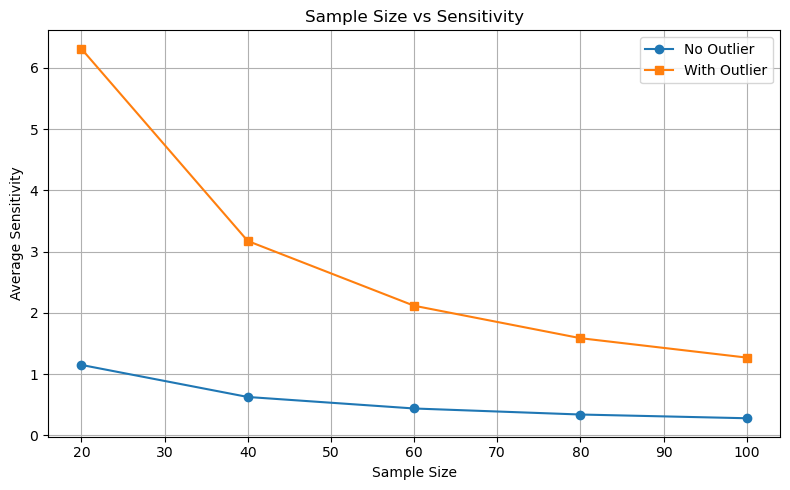

In [8]:
from src.sim import *

subsample_sizes = [20, 40, 60, 80, 100]

avg_sens_no = sim(subsample_sizes=subsample_sizes,outlier_=False)
avg_sens_wi = sim(subsample_sizes=subsample_sizes,outlier_=True)


plt.figure(figsize=(8, 5))
plt.plot(subsample_sizes, avg_sens_no, marker='o', label='No Outlier')
plt.plot(subsample_sizes, avg_sens_wi, marker='s', label='With Outlier')
plt.xlabel('Sample Size')
plt.ylabel('Average Sensitivity')
plt.title('Sample Size vs Sensitivity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
print(f"Average percentage across population:\n")
prc = dict()
for size in subsample_sizes:
    prc[size] = (id_dr[size] / n_replicates) * 100
    print(f"\t{str(size)}: {np.mean(prc[size])}")

print(f"Standard Error across population:\n")
for size in subsample_sizes:
    se = np.std(prc[size], ddof=1) / np.sqrt(len(prc[size]))
    print(f"\t{str(size)}: {se}")


Average percentage across population:

100: 99.962

80: 99.92875000000001

60: 99.90666666666667

40: 99.74000000000001

20: 98.775

Standard Error across population:

100: 0.035011686360673644

80: 0.05870958750116512

60: 0.0899738400985063

40: 0.1581463132996035

20: 0.32467595181074077

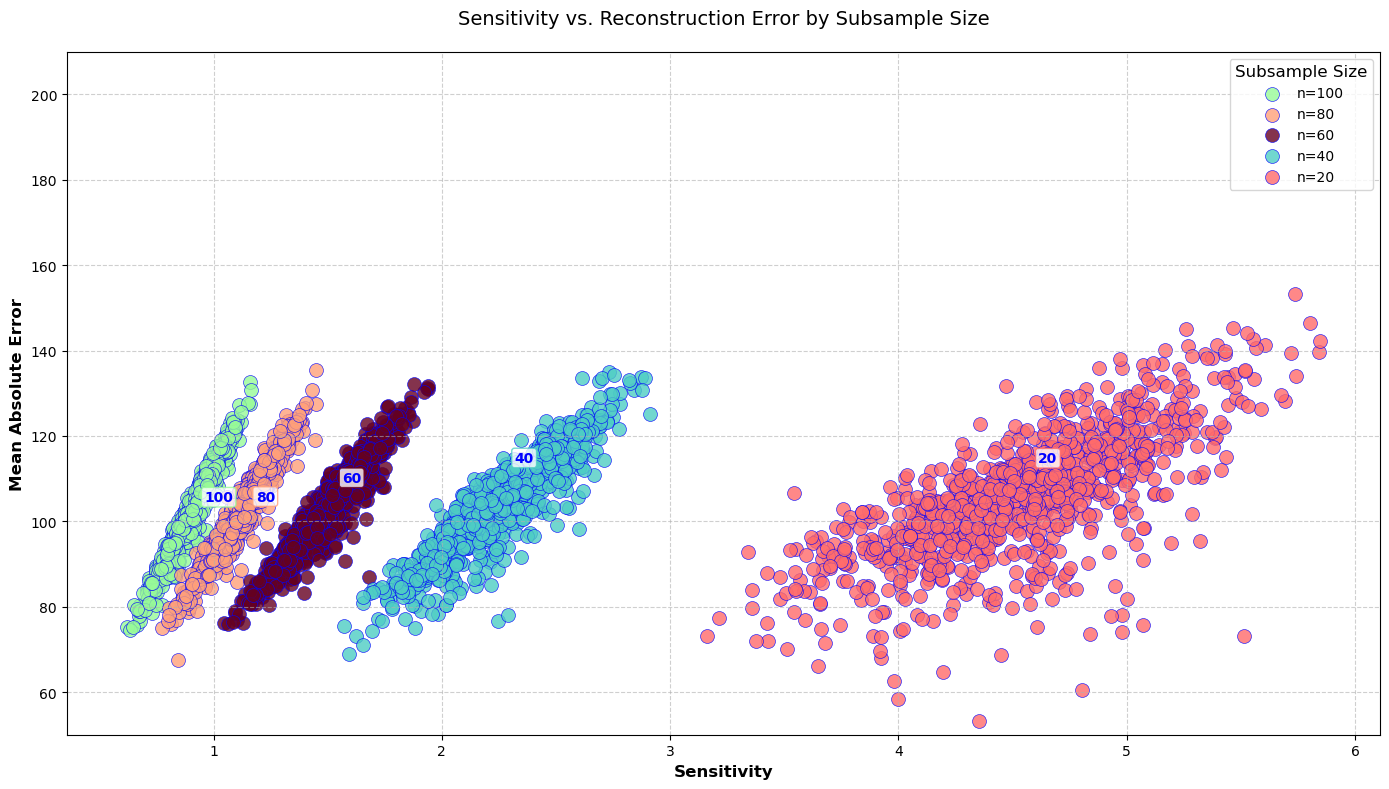

In [42]:
# https://matplotlib.org/stable/users/explain/colors/colors.html
color_map = {
    20: '#FF6B6B',  
    40: '#4ECDC4', 
    60: '#650021', 
    80: '#FFA07A',  
    100: '#98FB98' 
}

plt.figure(figsize=(14, 8))

for size in subsample_sizes:
    mean_sensitivity = np.mean(np.array(sensitivities_[size]), axis=1)
    plt.scatter(mean_sensitivity, 
                np.array(error_[size]),
                color=color_map[size],
                s=100,  
                alpha=0.8,
                edgecolors='b',  
                linewidth=0.5,
                label=f'n={size}')

    median_idx = np.argsort(mean_sensitivity)[len(mean_sensitivity)//2]
    plt.annotate(f'{size}',
                 xy=(mean_sensitivity[median_idx], np.array(error_[size])[median_idx]),
                 xytext=(10, 10),  
                 textcoords='offset points',
                 fontsize=10,
                 fontweight='bold',
                 color="b", 
                 bbox=dict(boxstyle='round,pad=0.2', 
                          fc='white', 
                          ec=color_map[size],  
                          alpha=0.8))

plt.ylim(50, 210)
plt.xlabel('Sensitivity', fontsize=12, fontweight='bold')
plt.ylabel('Mean Absolute Error', fontsize=12, fontweight='bold')
plt.title('Sensitivity vs. Reconstruction Error by Subsample Size', 
          fontsize=14, pad=20)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Subsample Size', title_fontsize=12)

plt.tight_layout()
plt.show()

## Sensitivity vs. Reconstruction Error by Population Size

This plot visualizes how sensitivity and reconstruction error interact under our privacy mechanism, across different dataset sizes.

- **X-axis (Sensitivity)**: The maximum change in the **mean** when one data point is removed (leave-one-out sensitivity).

- **Y-axis (Mean Absolute Error)**: The average error from attempting to reconstruct the original (non-noised) mean after noise has been added.

- **Colors**: Represent different population sizes (n = 20 to 100).

## What This Plot Shows

Smaller samples are more sensitive. As the population size decreases, the influence of a single data point increases. This leads to higher **sensitivity**, which is clearly seen on the right side of the plot for n = 20. As for higher **sensitivity** leads to higher reconstruction error. To preserve privacy, more noise is injected when sensitivity is higher. As a result, the reconstruction error increases, which is a desired effect which means the output is harder to reverse-engineer.



Larger samples have better privacy-utility balance. As sample size grows (e.g. n = 100 on the left), sensitivity drops because each individual has less impact on the mean. This means less noise is needed, and the reconstruction error drops accordingly, yielding better accuracy while still maintaining privacy. Aside from that, tight clustering by sample size, where each sample size forms a distinct cluster, indicating consistent behavior of the mechanism at each scale. This shows the sensitivity and resulting noise are well-behaved and predictable.

- High-risk cases (small n, high sensitivity) → more noise, higher error
- Low-risk cases (large n, low sensitivity) → less noise, better utility




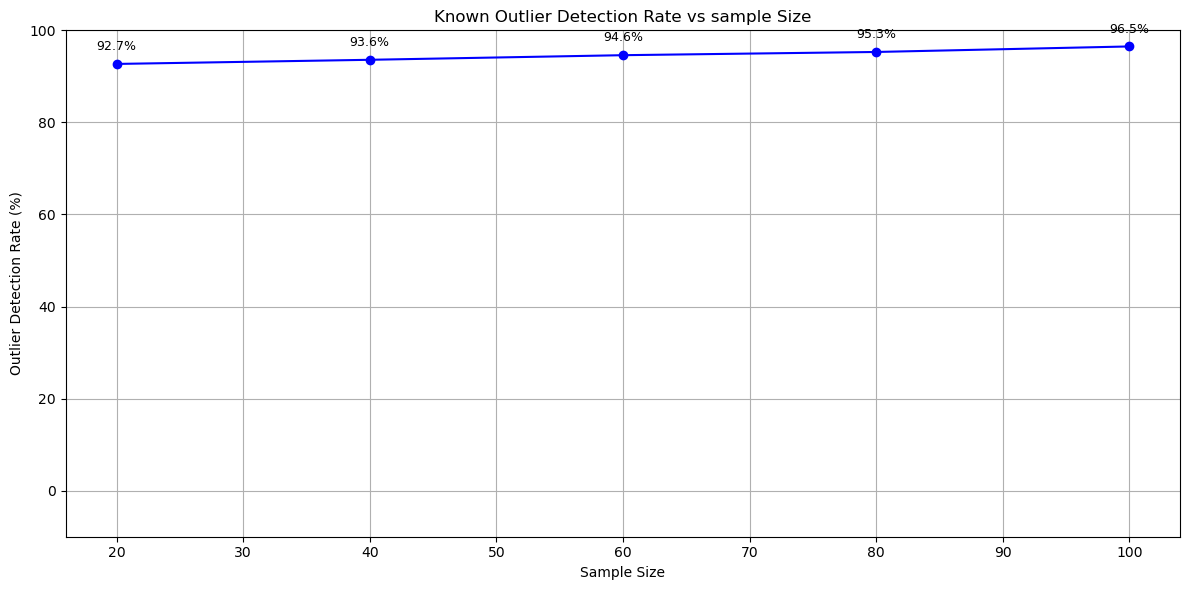

In [43]:
detection_rates = [(counts[size] / n_replicates) * 100 for size in subsample_sizes]

plt.figure(figsize=(12, 6))
plt.plot(subsample_sizes, detection_rates, marker='o', linestyle='-', color='blue')

for size, rate in zip(subsample_sizes, detection_rates):
    plt.annotate(
        f"{rate:.1f}%",
        (size, rate),    
        textcoords="offset points",  
        xytext=(0, 10),  
        ha='center',      
        fontsize=9       
    )

plt.xlabel('Sample Size')
plt.ylabel('Outlier Detection Rate (%)')
plt.title('Known Outlier Detection Rate vs sample Size')
plt.ylim(-10, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

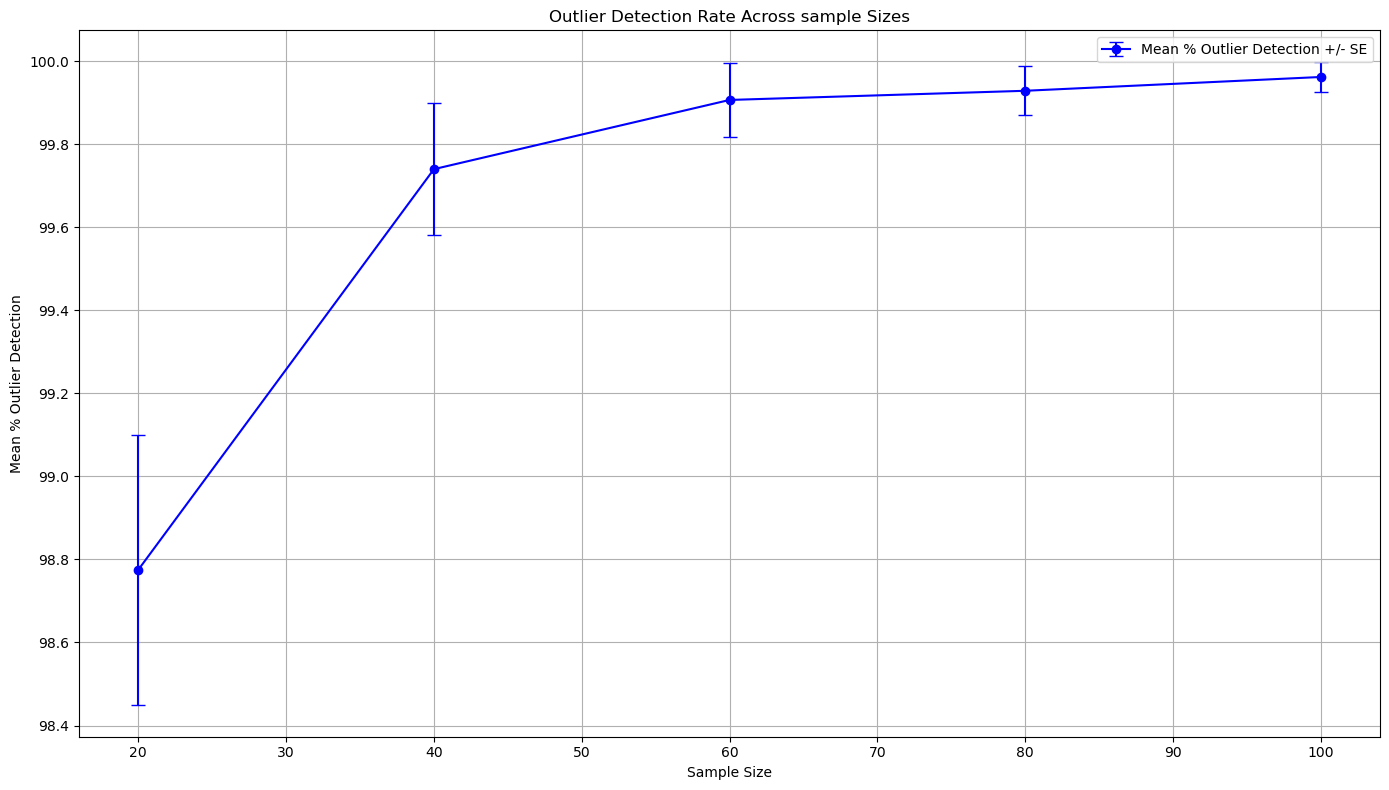

In [44]:
# (1) compute the percentage of time subject 1, 2, 3 etc were flagged outliers 
# (2) average these values along with the strandard error (for n=20, n=40, etc) and 
# (3) add the mean with standard error to the outlier detection plot
means, errors, pop_size = list(), list(), list()

for n, flags in id_dr.items():
    percentages = (flags / n_replicates) * 100
    mean = np.mean(percentages)
    se = np.std(percentages, ddof=1) / np.sqrt(len(flags))
    means.append(mean)
    errors.append(se)
    pop_size.append(n)

plt.figure(figsize=(14, 8))
plt.errorbar(pop_size, means, yerr=errors, fmt='-o', capsize=5, color='blue',label='Mean % Outlier Detection +/- SE')
plt.title('Outlier Detection Rate Across sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('Mean % Outlier Detection')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The outlier detection here refers to how often the injected noise produces an output that is statistically flagged as an outlier.

What this plot shows, is that across all subsample sizes, the outlier detection rate remains consistently at 0%. This means the added noise never creates anomalous or suspicious values, regardless of how large or small the sample is. The mechanism produces outputs that remain statistically plausible and naturally blend in with expected values.

However since the method is foundamentally based on randomness, and earlier we mentioned that smaller datasets are more sensetive, we can expect information breach in small datasets. 

### Comparison to local privacy

Local privacy is something that one is more accustomed to. We simply have to add noise on each subject. Of course in project in which the data are completely private this is not possible, which is why gobal privacy can be used. It is however beneficial to compare the approach and results here.

We start by creating the local_dp object which noise data rahter than user_output

In [54]:
def local_dp(clean_data):

    # now this is simply how far a subject is to the user_output
    sensitivity = np.abs(clean_data-user_output(clean_data))

    noise_values = np.zeros_like(clean_data)
    for i in range(len(clean_data)):
        while True:
            noise = np.random.laplace(loc=0.0, scale=sensitivity[i], size=1)
            if abs(noise[0]) >= sensitivity[i]:
                noise_values[i] = noise[0]
                break
    noisy_data = clean_data + noise_values
    #print("clean_data",clean_data)
    #print("noise_values",noise_values)
    #print("noisy_data",noisy_data)
    #print("sensitivity",sensitivity)
    #print("*"*50)
    return noisy_data, sensitivity

In [59]:
n_replicates = 1000
subsample_sizes = [20, 40, 60, 80, 100]

id_dr = {size: np.zeros(size) for size in subsample_sizes} # stands for index detection rates
counts = {size: 0 for size in subsample_sizes}
reconstructed = {size: [] for size in subsample_sizes}
true_means_ = {size: [] for size in subsample_sizes}
sensitivities_ = {size: [] for size in subsample_sizes}
error_ = {size: [] for size in subsample_sizes}

for _ in range(n_replicates):
    
    data = np.random.normal(loc=170, scale=10, size=100)
    for size in subsample_sizes:
        original_subsample = data[:size].copy()
        iqr_orig, lower_orig, upper_orig = iqr_bounds(original_subsample)
        outlier_value = lower_orig - 100
        subsample_w = original_subsample.copy()
        subsample_w[0] = outlier_value
        #print(subsample_w)
        true_mean = np.mean(subsample_w)
        true_means_[size].append(true_mean)
        loo_data = np.array([user_output(np.delete(subsample_w, i)) for i in range(len(subsample_w))])
        #print("loo_data",loo_data)
        ######## PIPELINE ########
        noisy_output, sensitivity_ = local_dp(loo_data)
        sensitivities_[size].append(sensitivity_)
        ######## RECONSTRUCTION ########
        n = size
        recons = np.linalg.solve(np.ones((n, n)) - np.eye(n), (n - 1) * np.array(noisy_output).flatten())
        #print("recons", recons)
        recons_error = np.mean(abs(recons - original_subsample))
        error_[size].append(recons_error)
        #print(f"recons_error: {recons_error}, error_[size]: {error_[size]}")
        reconstructed[size].append(recons)
        _, lower_rec, upper_rec = iqr_bounds(recons)
        #print(f"reconst: {recons[0]}, lower: {lower_rec}, upper: {upper_rec}")
        if outlier_(recons[0], lower_rec, upper_rec):
            counts[size] += 1
            
        for idx in range(size):
            #if outlier_(recons[idx], original_subsample[idx]):
            if outlier_(recons[idx], lower_rec, upper_rec):
                id_dr[size][idx] += 1


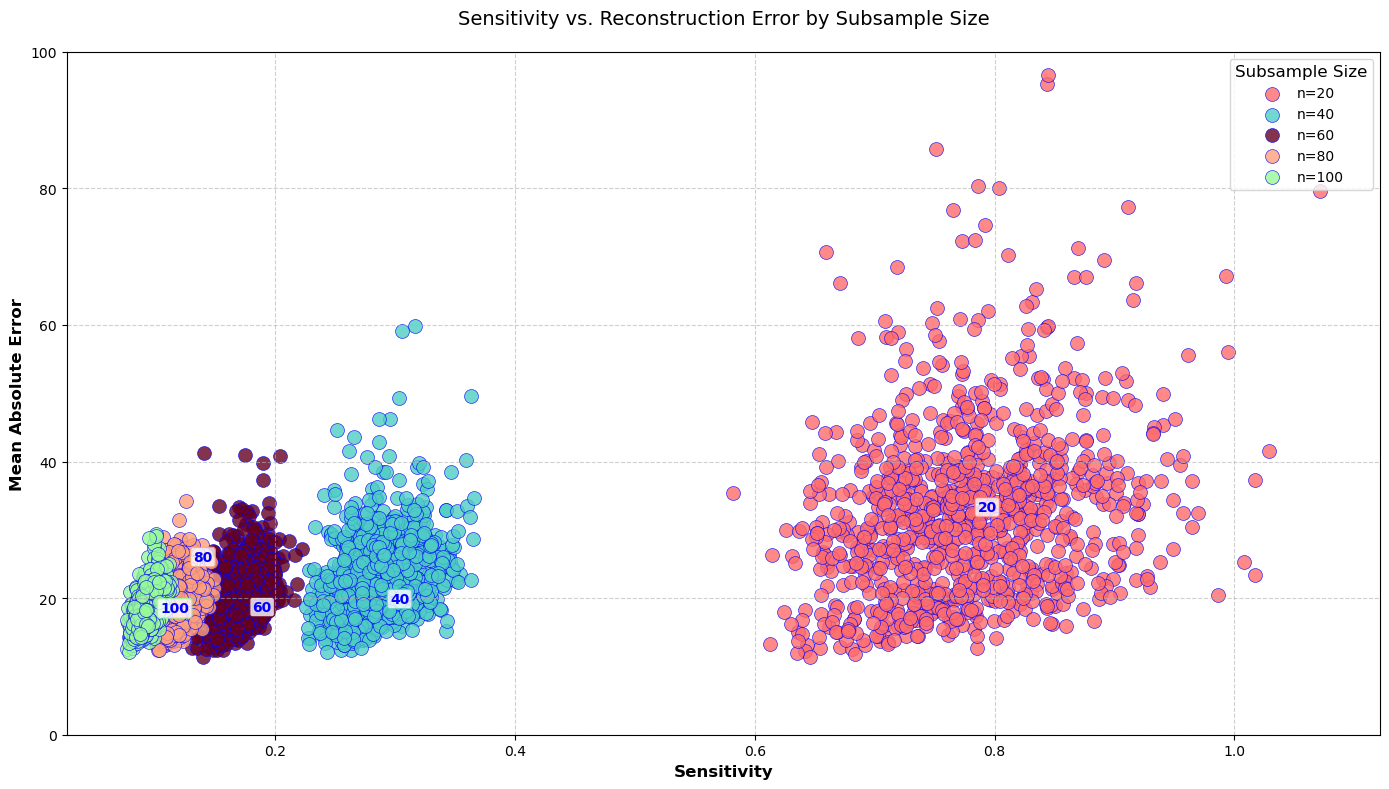

In [60]:
# https://matplotlib.org/stable/users/explain/colors/colors.html
color_map = {
    20: '#FF6B6B',  
    40: '#4ECDC4', 
    60: '#650021', 
    80: '#FFA07A',  
    100: '#98FB98' 
}

plt.figure(figsize=(14, 8))

for size in subsample_sizes:
    mean_sensitivity = np.mean(np.array(sensitivities_[size]), axis=1)
    plt.scatter(mean_sensitivity, 
                np.array(error_[size]),
                color=color_map[size],
                s=100,  
                alpha=0.8,
                edgecolors='b',  
                linewidth=0.5,
                label=f'n={size}')

    median_idx = np.argsort(mean_sensitivity)[len(mean_sensitivity)//2]
    plt.annotate(f'{size}',
                 xy=(mean_sensitivity[median_idx], np.array(error_[size])[median_idx]),
                 xytext=(10, 10),  
                 textcoords='offset points',
                 fontsize=10,
                 fontweight='bold',
                 color="b", 
                 bbox=dict(boxstyle='round,pad=0.2', 
                          fc='white', 
                          ec=color_map[size],  
                          alpha=0.8))

plt.ylim(0, 100)
plt.xlabel('Sensitivity', fontsize=12, fontweight='bold')
plt.ylabel('Mean Absolute Error', fontsize=12, fontweight='bold')
plt.title('Sensitivity vs. Reconstruction Error by Subsample Size', 
          fontsize=14, pad=20)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Subsample Size', title_fontsize=12)

plt.tight_layout()
plt.show()

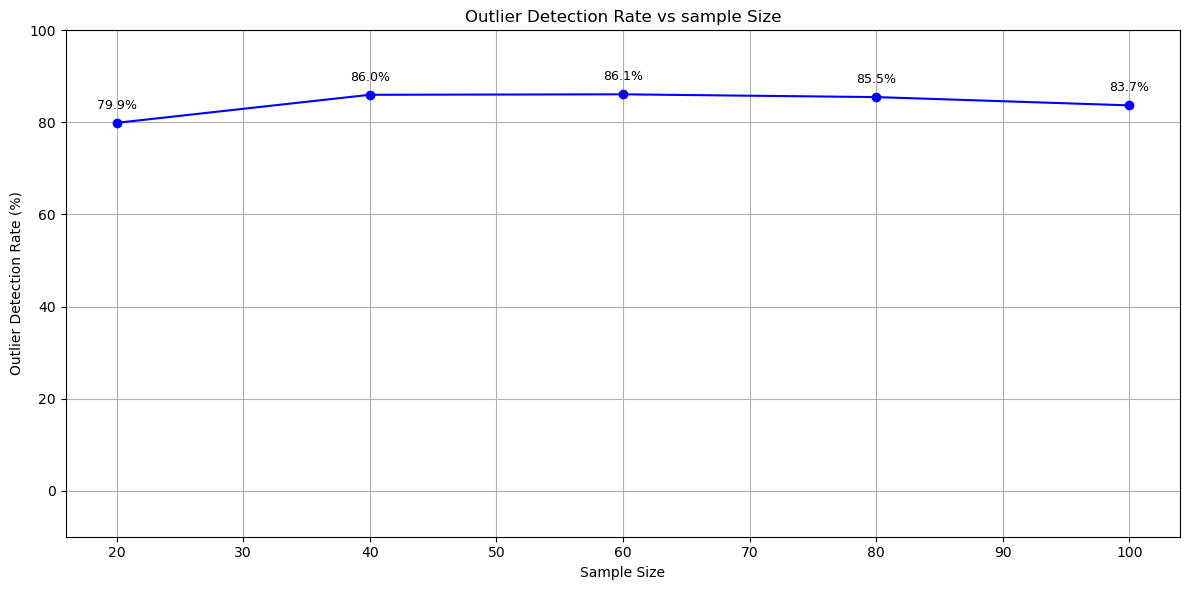

In [61]:
detection_rates = [(counts[size] / n_replicates) * 100 for size in subsample_sizes]

plt.figure(figsize=(12, 6))
plt.plot(subsample_sizes, detection_rates, marker='o', linestyle='-', color='blue')

for size, rate in zip(subsample_sizes, detection_rates):
    plt.annotate(
        f"{rate:.1f}%",
        (size, rate),    
        textcoords="offset points",  
        xytext=(0, 10),  
        ha='center',      
        fontsize=9       
    )

plt.xlabel('Sample Size')
plt.ylabel('Outlier Detection Rate (%)')
plt.title('Outlier Detection Rate vs sample Size')
plt.ylim(-10, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

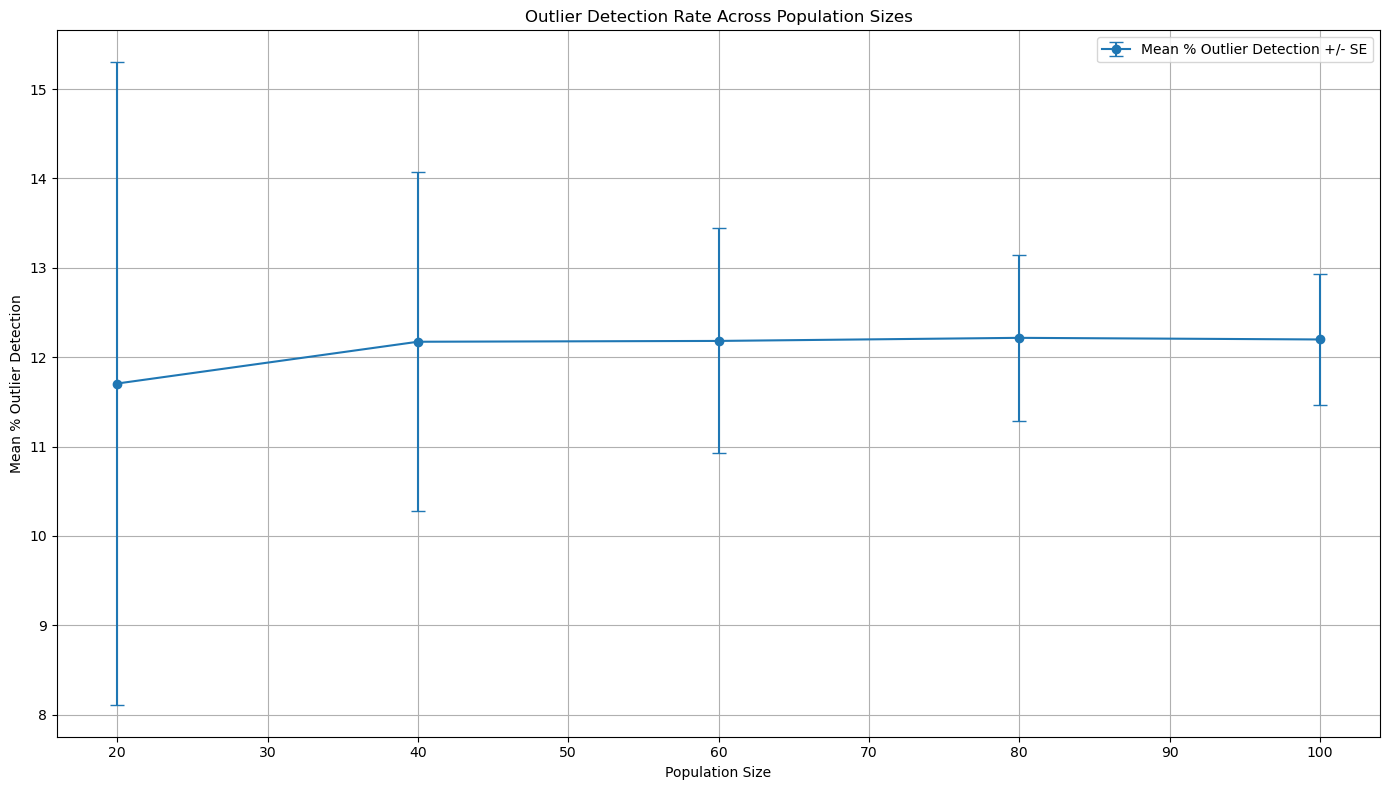

In [62]:
# (1) compute the percentage of time subject 1, 2, 3 etc were flagged outliers 
# (2) average these values along with the strandard error (for n=20, n=40, etc) and 
# (3) add the mean with standard error to the outlier detection plot
means, errors, pop_size = list(), list(), list()

for n, flags in id_dr.items():
    percentages = (flags / n_replicates) * 100
    mean = np.mean(percentages)
    se = np.std(percentages, ddof=1) / np.sqrt(len(flags))
    means.append(mean)
    errors.append(se)
    pop_size.append(n)

plt.figure(figsize=(14, 8))
plt.errorbar(pop_size, means, yerr=errors, fmt='-o', capsize=5, label='Mean % Outlier Detection +/- SE')
plt.title('Outlier Detection Rate Across Population Sizes')
plt.xlabel('Population Size')
plt.ylabel('Mean % Outlier Detection')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# TEST LOCAL DP

In [88]:
clean_data = np.array([1.73, 1.8, 1.85, 1.79, 3.0])


In [145]:
print("clean",clean_data)
n = len(clean_data)
loo_data = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
print("loo_data",loo_data)
recons = np.linalg.solve(np.ones((n, n)) - np.eye(n), (n - 1) * np.array(loo_data).flatten())
print("re-constructed",recons)

clean [1.73 1.8  1.85 1.79 3.  ]

loo_data [2.11   2.0925 2.08   2.095  1.7925]

re-constructed [1.73 1.8  1.85 1.79 3.  ]

In [90]:
noisy_data, _ = local_dp(loo_data)
print("noisy",noisy_data)
recons = np.linalg.solve(np.ones((n, n)) - np.eye(n), (n - 1) * np.array(noisy_data).flatten())
print("re-constructed from noisy",recons)

noisy [1.98852193 2.18645486 1.89806508 2.20104838 1.40226343]

re-constructed from noisy [1.72226595 0.93053423 2.08409337 0.87216017 4.06729997]

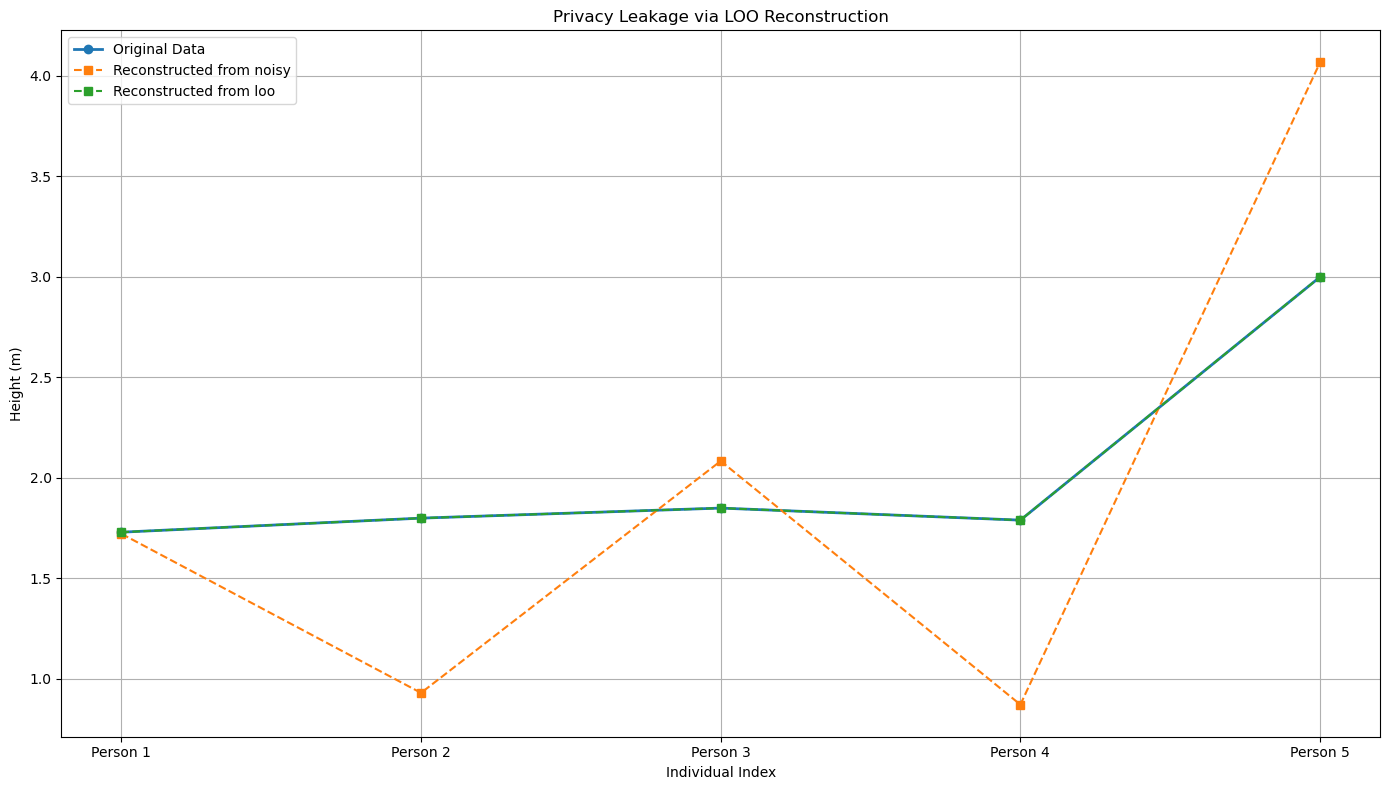

In [91]:
indices = np.arange(len(clean_data))
plt.figure(figsize=(14, 8))
plt.plot(indices, clean_data, marker='o', label='Original Data', linewidth=2)
plt.plot(indices, np.linalg.solve(np.ones((n, n)) - np.eye(n), (n - 1) * np.array(noisy_data).flatten()), marker='s', label='Reconstructed from noisy', linestyle='--')
plt.plot(indices, np.linalg.solve(np.ones((n, n)) - np.eye(n), (n - 1) * np.array(loo_data).flatten()), marker='s', label='Reconstructed from loo', linestyle='--')

plt.title("Privacy Leakage via LOO Reconstruction")
plt.xlabel("Individual Index")
plt.ylabel("Height (m)")
plt.xticks(indices, [f"Person {i + 1}" for i in indices])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [113]:
n_replicates = 1000
id_dr = np.full(5, np.zeros(1)) # stands for index detection rates
counts = 0
reconstructed = []
true_means_ = []
sensitivities_ = []
error_ = []

for _ in range(n_replicates):
    original_subsample = np.array([1.73, 1.8, 1.85, 1.79, 3.0])

    iqr_orig, lower_orig, upper_orig = iqr_bounds(original_subsample)
    outlier_value = lower_orig - 100
    subsample_w = original_subsample.copy()
    subsample_w[-1] = outlier_value
    true_mean = np.mean(subsample_w)
    true_means_.append(true_mean)
    loo_data = np.array([user_output(np.delete(subsample_w, i)) for i in range(len(subsample_w))])
    ######## PIPELINE ########
    noisy_output, sensitivity_ = local_dp(loo_data)
    sensitivities_.append(sensitivity_)
    ######## RECONSTRUCTION ########
    n = 5
    recons = np.linalg.solve(np.ones((n, n)) - np.eye(n), (n - 1) * np.array(noisy_output).flatten())
    recons_error = np.mean(abs(recons - original_subsample))
    error_.append(recons_error)
    reconstructed.append(recons)
    _, lower_rec, upper_rec = iqr_bounds(recons)
    if outlier_(recons[-1], lower_rec, upper_rec):
        counts += 1
        
    for idx in range(len(original_subsample)):
        if outlier_(recons[idx], lower_rec, upper_rec):
            id_dr[idx] += 1


In [124]:
print(id_dr)

[ 50.  49.  71.  51. 593.]

Standard Error is scaled by 500

standard error: 3.4460121880225554

standard error: 3.413173010557771

standard error: 4.060757318530621

standard error: 3.47846949102619

standard error: 7.767737765913574

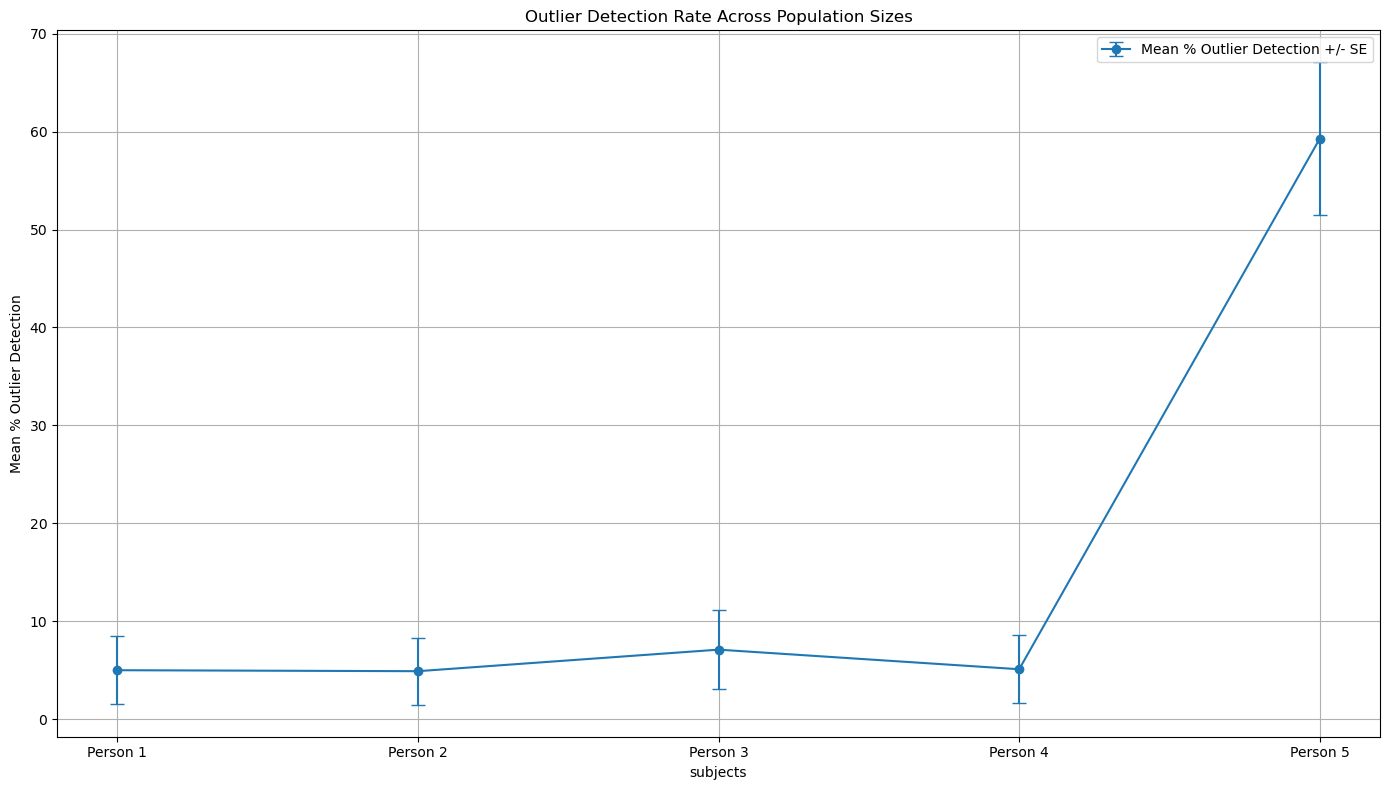

In [163]:
means, errors, pop_size = list(), list(), list()
print("Standard Error is scaled by 500")
print()
for n, flags in enumerate(id_dr):
    percentages = (flags / n_replicates) * 100
    mean = np.mean(percentages)
    p_hat = flags / n_replicates
    se = np.sqrt(p_hat * (1 - p_hat) / n_replicates) * 500
    print(f"standard error: {se}")
    means.append(mean)
    errors.append(se)
    pop_size.append(n)

plt.figure(figsize=(14, 8))
plt.errorbar(pop_size, means, yerr=errors, fmt='-o', capsize=5, label='Mean % Outlier Detection +/- SE')
plt.title('Outlier Detection Rate Across Population Sizes')
plt.xlabel('subjects')
plt.ylabel('Mean % Outlier Detection')
plt.xticks(indices, [f"Person {i + 1}" for i in indices])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
